# Predicting winners of League of Legends games through data analysis

## Import all necessary packages

In [0]:
import pyspark
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

## 1. Data Acquisition, Exploration and Preprocessing

### 1.1 Acquisition

In [0]:
# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# We subsequently load the three files (Master, granmaster and challenger games), in order to unify them under a unique dataframe (as they share the same set of features).
file_location = "/FileStore/tables/Master_Ranked_Games-1.csv"
file_type = "csv"
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

file_location_2 = "/FileStore/tables/GrandMaster_Ranked_Games-1.csv"
df2 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location_2)

file_location_3 = "/FileStore/tables/Challenger_Ranked_Games-1.csv"
df3 = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location_3)

In [0]:
#Unify the three dataframes to form our final dataframe
df_finale = df.union(df2).union(df3)
display(df_finale)

_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c26,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,_c40,_c41,_c42,_c43,_c44,_c45,_c46,_c47,_c48,_c49
gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,blueTowerKills,blueInhibitorKills,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt,redWins,redFirstBlood,redFirstTower,redFirstBaron,redFirstDragon,redFirstInhibitor,redDragonKills,redBaronKills,redTowerKills,redInhibitorKills,redWardPlaced,redWardkills,redKills,redDeath,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
4227123625,1429,0,1,1,0,0,0,0,0,4,0,75,33,7,19,13,42979,41910,646,60,12.0,180,2,15575,35335,1,0,0,0,1,0,3,0,2,0,89,37,19,7,45,53831,41991,609,64,12.8,127,4,12916,26338
4219545724,1313,0,0,1,0,0,0,0,0,3,0,45,13,6,22,9,36087,35880,563,56,11.2,119,1,13059,26348,1,1,0,0,1,0,2,0,1,0,64,20,22,6,43,52924,39672,510,63,12.6,133,4,12252,29828
4219463634,1660,1,0,0,1,1,1,1,1,9,2,66,31,30,13,61,64708,58214,651,74,14.8,209,7,37288,64577,0,1,1,0,0,0,2,0,3,0,78,16,13,30,22,61745,46516,630,65,13.0,153,2,17005,37066
4205778093,984,1,1,1,0,1,0,2,0,5,0,55,9,26,3,34,45772,36545,402,53,10.6,102,6,14093,31303,0,0,0,0,0,0,0,0,0,0,33,11,3,26,5,25007,21444,304,41,8.2,51,1,10499,3085
4201063474,1437,0,1,1,0,1,0,2,0,3,0,75,23,19,24,22,79501,42395,528,60,12.0,96,5,23863,30643,1,0,0,0,0,0,1,0,4,0,70,32,23,19,39,71794,45798,565,68,13.6,150,7,47523,47150
4169807983,1109,1,0,1,0,1,0,2,0,3,0,43,22,19,9,30,52628,37722,484,58,11.6,111,4,20715,38287,0,1,0,0,0,0,0,0,0,0,54,16,9,19,12,45339,29401,402,51,10.2,92,2,24150,11133
4158792026,1845,1,1,1,0,1,1,4,1,9,2,71,39,35,25,58,84049,65775,690,79,15.8,221,9,26997,89993,0,0,0,1,0,0,1,1,3,0,85,29,25,35,39,60275,60427,751,75,15.0,158,6,15773,40996
4150560544,951,0,0,0,0,1,0,1,0,0,0,37,18,1,12,3,23320,23282,411,46,9.2,116,0,11617,14852,1,1,1,0,0,0,1,0,1,0,43,13,12,1,13,30998,29217,427,50,10.0,89,5,12255,12166
4131183383,1473,1,1,1,1,0,1,2,1,9,2,61,24,35,17,35,77143,54193,586,69,13.8,161,9,29311,66138,0,0,0,0,1,0,1,0,0,0,57,26,17,35,24,59054,41460,520,61,12.2,123,4,26826,11415


In [0]:
mapping = df.first()

### 1.2 Exploration and Preprocessing

In [0]:
#We remove columns that directly correlate with the target feature, or that are useless. Infact, _c26 is associated to the "RedWins" Feature; since our target feature is "BlueWins", and the two are complementary, _c26 is to be removed. On the other hand, _c0 is associated to a useless feature ("gameID").
df = df_finale.drop('_c26')
df = df.drop('_c0')

In [0]:
#Before removing the old column names, we save them in a list: this way, we will be able to provide a mapping from column names (es: _c12) to feature names (es: BlueTowerKills), in order to game some insight on which features contribute more to the Blue Team victory.
feature_names = [name for name in df.first()]


In [0]:
#We remove the first row, containing those that were the names of the columns in the original csv dataset
df = df.where("_c1 != 'gameDuraton'")

In [0]:
#We save the features in a list (_c2 is excluded, as it's our target feature), and then pass it to pyspark's assembler class. We then reshape our df, in order to make it transformable by our assembler
features = [feat for feat in df.columns if feat != '_c2']
assembler = VectorAssembler(inputCols = features, outputCol="features")
for col in df.columns:
  df = df.withColumn(col, df[col].cast(IntegerType()))
df.printSchema()

root
-- _c1: integer (nullable = true)
-- _c2: integer (nullable = true)
-- _c3: integer (nullable = true)
-- _c4: integer (nullable = true)
-- _c5: integer (nullable = true)
-- _c6: integer (nullable = true)
-- _c7: integer (nullable = true)
-- _c8: integer (nullable = true)
-- _c9: integer (nullable = true)
-- _c10: integer (nullable = true)
-- _c11: integer (nullable = true)
-- _c12: integer (nullable = true)
-- _c13: integer (nullable = true)
-- _c14: integer (nullable = true)
-- _c15: integer (nullable = true)
-- _c16: integer (nullable = true)
-- _c17: integer (nullable = true)
-- _c18: integer (nullable = true)
-- _c19: integer (nullable = true)
-- _c20: integer (nullable = true)
-- _c21: integer (nullable = true)
-- _c22: integer (nullable = true)
-- _c23: integer (nullable = true)
-- _c24: integer (nullable = true)
-- _c25: integer (nullable = true)
-- _c27: integer (nullable = true)
-- _c28: integer (nullable = true)
-- _c29: integer (nullable = true)
-- _c30: integer (nullable = true)
-- _c31: integer (nullable = true)
-- _c32: integer (nullable = true)
-- _c33: integer (nullable = true)
-- _c34: integer (nullable = true)
-- _c35: integer (nullable = true)
-- _c36: integer (nullable = true)
-- _c37: integer (nullable = true)
-- _c38: integer (nullable = true)
-- _c39: integer (nullable = true)
-- _c40: integer (nullable = true)
-- _c41: integer (nullable = true)
-- _c42: integer (nullable = true)
-- _c43: integer (nullable = true)
-- _c44: integer (nullable = true)
-- _c45: integer (nullable = true)
-- _c46: integer (nullable = true)
-- _c47: integer (nullable = true)
-- _c48: integer (nullable = true)
-- _c49: integer (nullable = true)

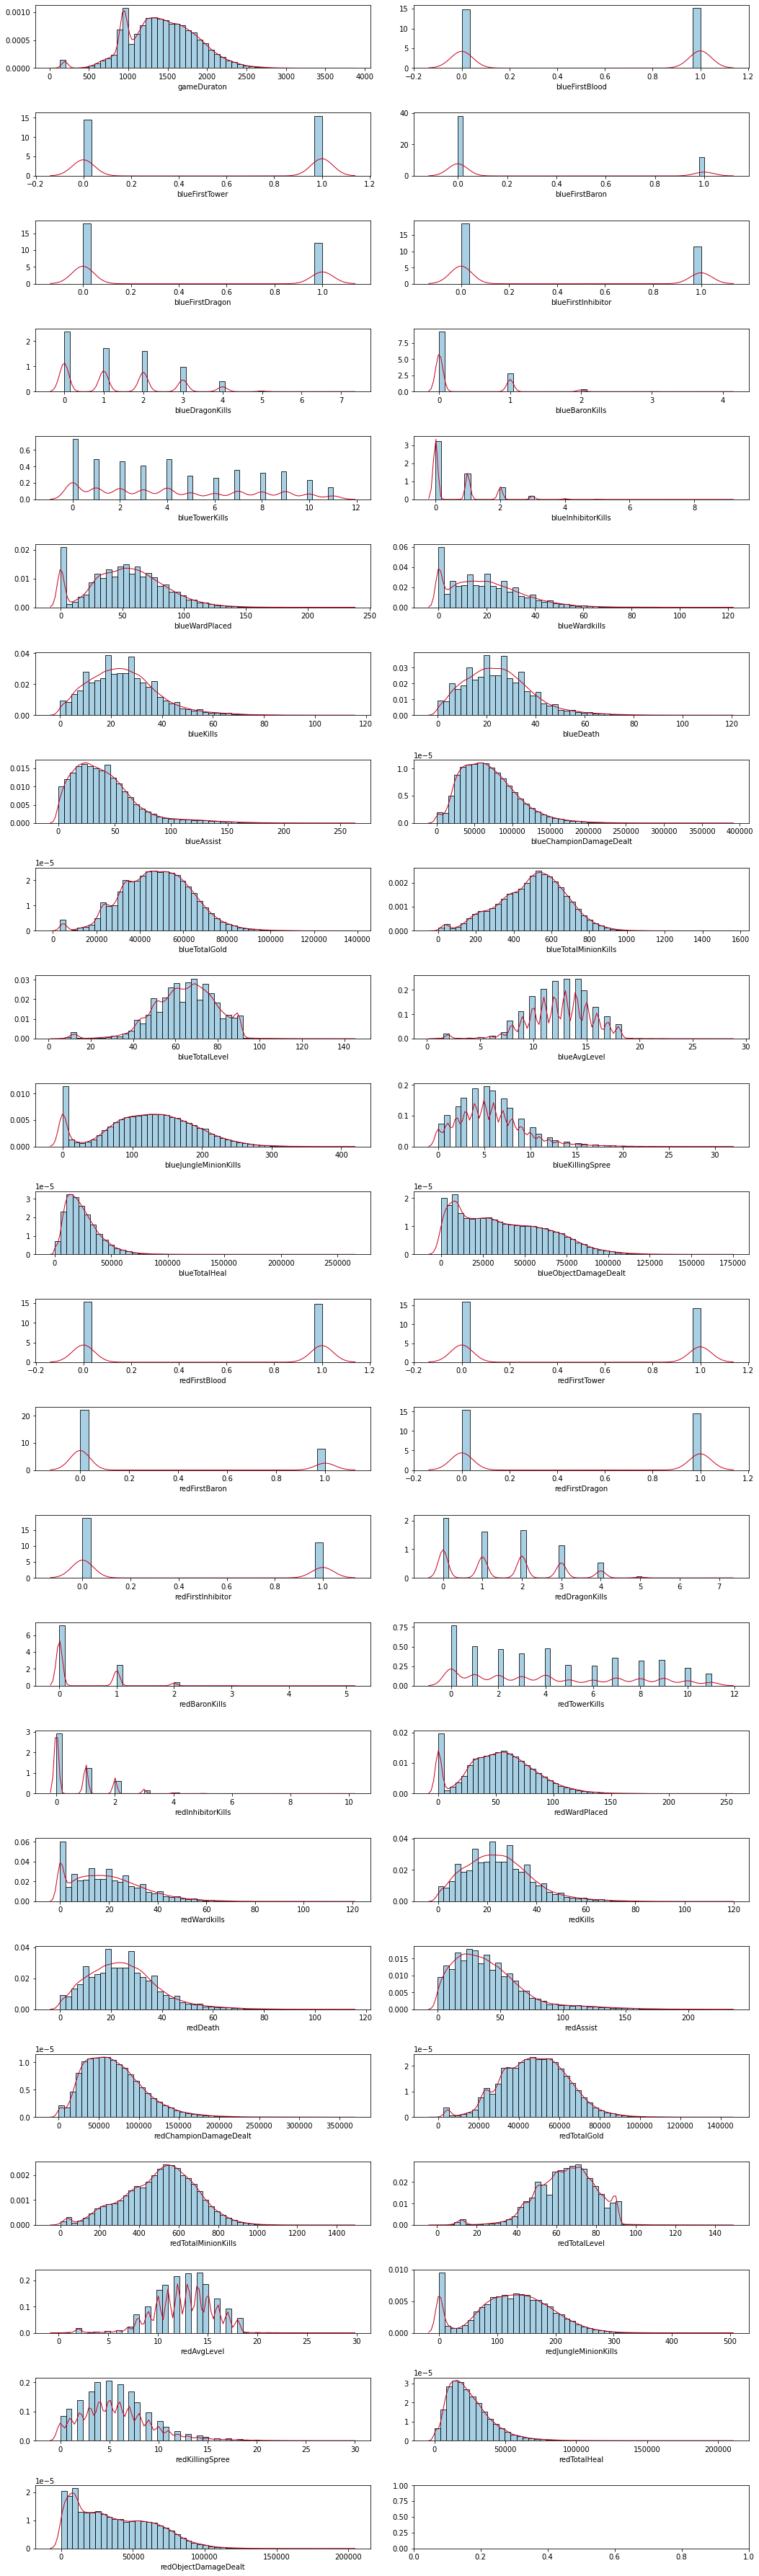

In [0]:
#Display distribution graphs for every feature 

import seaborn as sns
pdf = df.toPandas()
# Plot the distribution of values of each column of interest
n_rows = 24
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 50))

for i,f in enumerate(features):
    _ = sns.distplot(pdf[f],
                    axlabel = mapping[f],
                    kde_kws={"color": "#ca0020", "lw": 1}, 
                    hist_kws={"histtype": "bar", "edgecolor": "k", "linewidth": 1,"alpha": 0.8, "color": "#92c5de"},
                    ax=axes[i//n_cols, i%n_cols]
                    )

#fig.delaxes(axes[3][1]) # Remove the last cell of the plot

fig.tight_layout(pad=2)

Out[10]:

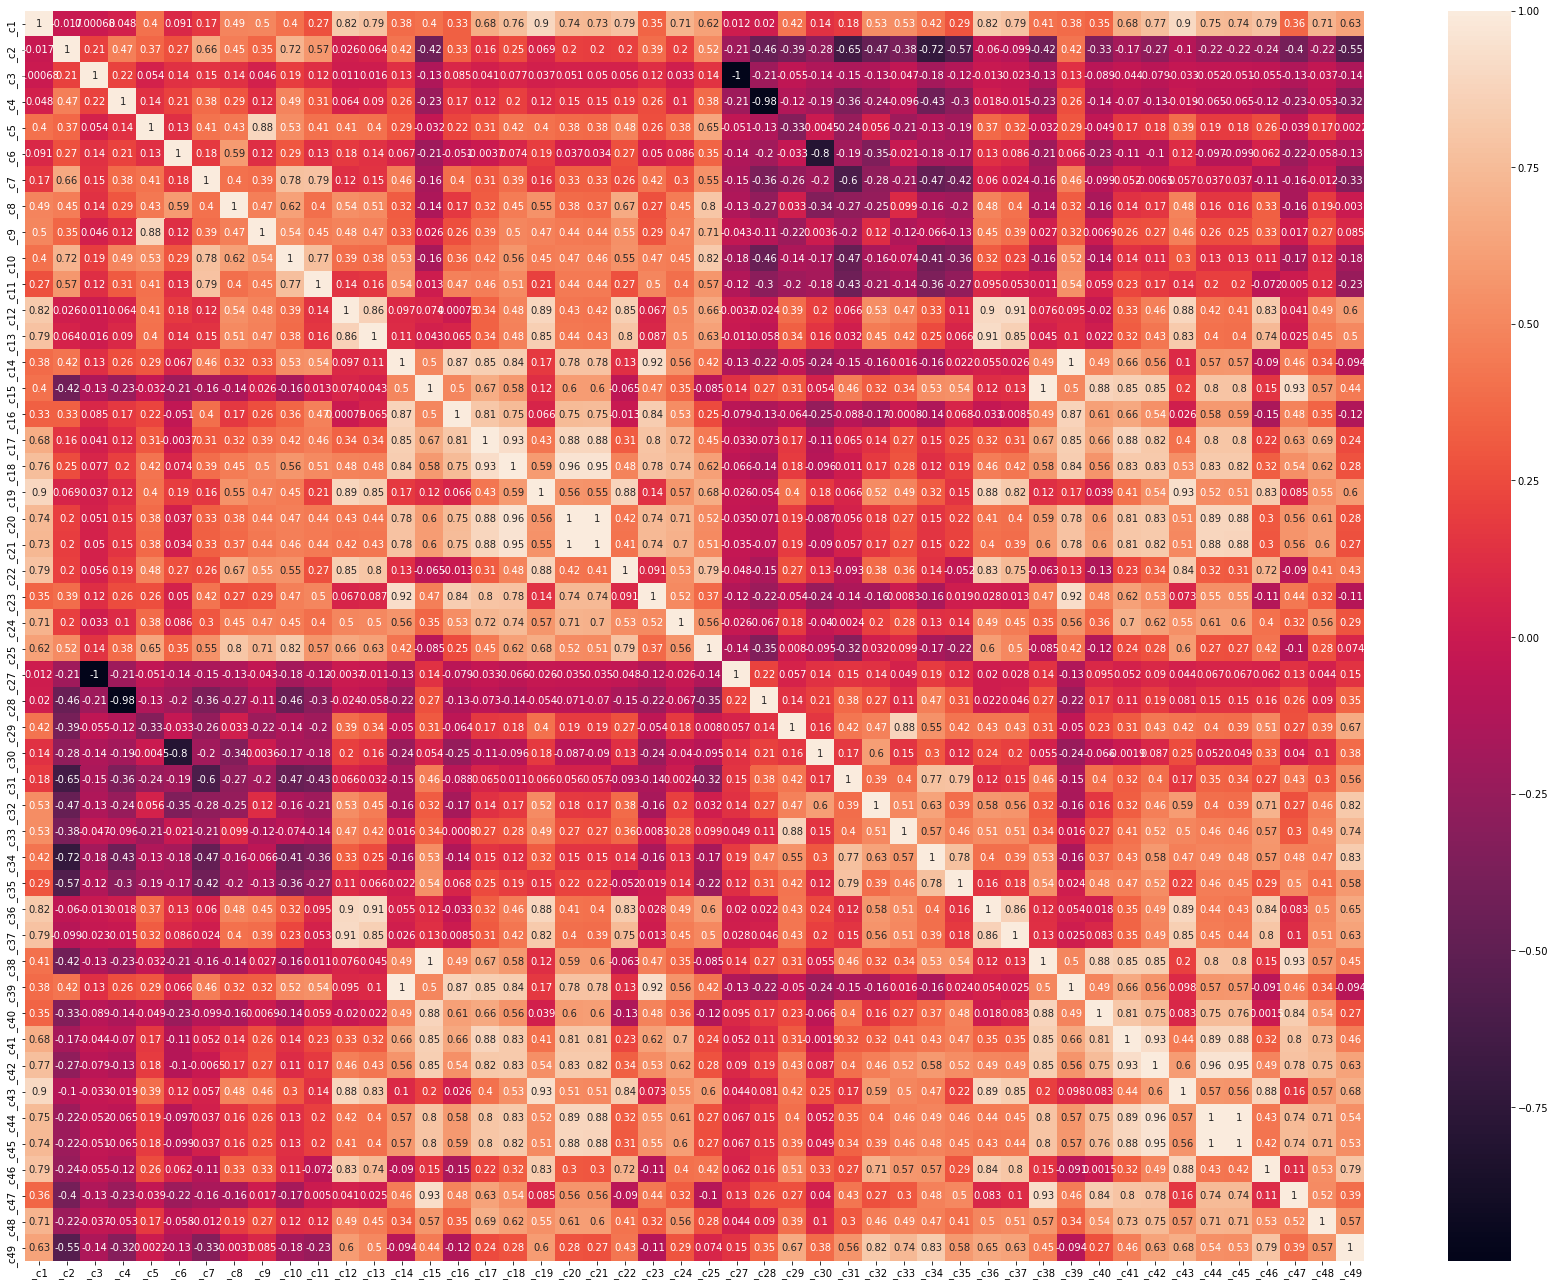

<matplotlib.axes._subplots.AxesSubplot at 0x7f85b89d0fd0>

In [0]:
dfp = df.toPandas()
plt.subplots(figsize=(30,23))
sns.heatmap(dfp.corr(), annot=True)

In [0]:
#We save the features in a list (_c2 is excluded, as it's our target feature), and then pass it to pyspark's assembler class. We then reshape our df, in order to make it transformable by our assembler
features = [feat for feat in df.columns if feat != '_c2']
assembler = VectorAssembler(inputCols = features, outputCol="features")
for col in df.columns:
  df = df.withColumn(col, df[col].cast(IntegerType()))
df.printSchema()

root
-- _c1: integer (nullable = true)
-- _c2: integer (nullable = true)
-- _c3: integer (nullable = true)
-- _c4: integer (nullable = true)
-- _c5: integer (nullable = true)
-- _c6: integer (nullable = true)
-- _c7: integer (nullable = true)
-- _c8: integer (nullable = true)
-- _c9: integer (nullable = true)
-- _c10: integer (nullable = true)
-- _c11: integer (nullable = true)
-- _c12: integer (nullable = true)
-- _c13: integer (nullable = true)
-- _c14: integer (nullable = true)
-- _c15: integer (nullable = true)
-- _c16: integer (nullable = true)
-- _c17: integer (nullable = true)
-- _c18: integer (nullable = true)
-- _c19: integer (nullable = true)
-- _c20: integer (nullable = true)
-- _c21: integer (nullable = true)
-- _c22: integer (nullable = true)
-- _c23: integer (nullable = true)
-- _c24: integer (nullable = true)
-- _c25: integer (nullable = true)
-- _c27: integer (nullable = true)
-- _c28: integer (nullable = true)
-- _c29: integer (nullable = true)
-- _c30: integer (nullable = true)
-- _c31: integer (nullable = true)
-- _c32: integer (nullable = true)
-- _c33: integer (nullable = true)
-- _c34: integer (nullable = true)
-- _c35: integer (nullable = true)
-- _c36: integer (nullable = true)
-- _c37: integer (nullable = true)
-- _c38: integer (nullable = true)
-- _c39: integer (nullable = true)
-- _c40: integer (nullable = true)
-- _c41: integer (nullable = true)
-- _c42: integer (nullable = true)
-- _c43: integer (nullable = true)
-- _c44: integer (nullable = true)
-- _c45: integer (nullable = true)
-- _c46: integer (nullable = true)
-- _c47: integer (nullable = true)
-- _c48: integer (nullable = true)
-- _c49: integer (nullable = true)

In [0]:
#save a sample for later testing
df, sample = df.randomSplit([0.9999, 0.0001])
display(sample)

_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13,_c14,_c15,_c16,_c17,_c18,_c19,_c20,_c21,_c22,_c23,_c24,_c25,_c27,_c28,_c29,_c30,_c31,_c32,_c33,_c34,_c35,_c36,_c37,_c38,_c39,_c40,_c41,_c42,_c43,_c44,_c45,_c46,_c47,_c48,_c49
1446,1,1,0,1,1,1,2,1,7,1,56,30,17,13,26,53066,48536,610,67,13,168,4,24891,54573,0,1,0,0,0,1,0,2,0,58,17,13,17,21,44106,39661,520,62,12,130,2,15299,29443
2138,1,1,1,1,0,1,3,1,9,1,87,29,44,31,86,144913,72248,685,83,16,204,12,40797,67122,0,0,0,1,0,3,0,4,0,79,45,31,44,67,142076,65515,762,80,16,199,5,37698,36578
2391,0,1,1,1,0,1,1,1,7,1,117,71,20,32,20,119714,70128,892,79,15,293,5,32678,77416,0,0,0,1,0,4,2,8,1,135,56,32,20,71,117546,77342,873,88,17,270,4,68985,111615
1230,1,1,1,0,0,1,0,0,9,2,40,9,25,10,27,56113,42909,535,62,12,87,5,24231,38268,0,0,0,1,0,2,0,0,0,31,8,10,25,13,42635,31725,436,54,10,106,1,17251,17559
2049,0,0,0,0,1,0,4,0,1,0,57,23,27,44,50,100028,59889,739,77,15,179,5,55424,27211,1,1,1,0,1,1,2,11,3,62,25,44,27,97,152924,69966,598,84,16,231,11,70696,100952
924,0,0,0,0,1,0,1,0,0,0,19,13,10,16,9,24510,24358,341,45,9,68,1,7189,10327,1,1,0,0,0,1,0,2,0,34,6,16,10,16,26396,29686,363,49,9,68,5,7585,22160
1276,1,0,1,0,1,1,3,0,9,1,43,14,18,9,31,45393,41722,462,60,12,163,5,35534,62087,1,0,0,0,0,0,0,1,0,46,18,9,18,18,33910,32437,472,54,10,69,3,8844,11074
1000,1,1,1,0,0,1,1,0,7,1,33,10,25,3,32,37657,36098,387,53,10,100,6,9275,29690,0,0,0,1,0,1,0,0,0,24,5,3,25,0,17843,22349,296,43,8,83,0,6569,13342
1760,0,0,0,0,0,0,1,0,3,0,83,27,19,25,30,81850,46301,568,67,13,130,5,46566,30263,1,1,1,1,1,3,1,8,1,85,39,25,19,45,100250,55707,631,73,14,174,6,41965,59367
1057,1,0,1,0,1,0,2,0,3,0,36,12,18,7,20,37337,33700,397,53,10,89,5,26666,21075,1,0,0,0,0,0,0,0,0,30,6,7,18,12,36746,26202,337,48,9,81,2,9812,10262


In [0]:
#We then transform the dataset in its final form, ready to be split and passed to Pyspark's Classification models.
output = assembler.transform(df)
df_final = output.select("features", "_c2")
display(df_final)

features,_c2
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 15, 16, 17, 18, 19, 20, 22, 23, 33, 38, 39, 40, 41, 42, 43, 45), values -> List(190.0, 1395.0, 4288.0, 30.0, 11.0, 2.0, 12.0, 727.0, 712.0, 4.0, 1681.0, 4827.0, 52.0, 13.0, 2.0, 16.0, 1330.0))",0
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46), values -> List(190.0, 1.0, 1.0, 1.0, 1.0, 1605.0, 4733.0, 30.0, 11.0, 2.0, 16.0, 1822.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1206.0, 5037.0, 46.0, 13.0, 2.0, 12.0, 571.0, 35.0))",0
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46), values -> List(190.0, 2.0, 1.0, 1.0, 1.0, 3311.0, 4305.0, 20.0, 10.0, 2.0, 8.0, 491.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2358.0, 4687.0, 37.0, 11.0, 2.0, 4.0, 844.0, 253.0))",0
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 10, 11, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46), values -> List(190.0, 2.0, 1.0, 1.0, 2207.0, 4337.0, 28.0, 11.0, 2.0, 16.0, 1257.0, 431.0, 1.0, 3.0, 1.0, 1.0, 2634.0, 5110.0, 40.0, 13.0, 2.0, 8.0, 875.0, 207.0))",0
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 10, 11, 15, 16, 17, 18, 19, 20, 22, 33, 34, 38, 39, 40, 41, 42, 43, 45, 46), values -> List(190.0, 3.0, 1.0, 2204.0, 4262.0, 28.0, 11.0, 2.0, 12.0, 803.0, 3.0, 1.0, 1039.0, 4532.0, 43.0, 13.0, 2.0, 12.0, 1402.0, 470.0))",0
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 33, 35, 38, 39, 40, 41, 42, 45, 46), values -> List(190.0, 1.0, 892.0, 4454.0, 32.0, 13.0, 2.0, 16.0, 722.0, 34.0, 1.0, 1.0, 1.0, 811.0, 4251.0, 26.0, 8.0, 1.0, 101.0, 77.0))",1
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 1, 10, 12, 14, 15, 16, 17, 18, 19, 20, 22, 33, 36, 38, 39, 40, 41, 42, 45), values -> List(190.0, 1.0, 4.0, 1.0, 1.0, 2647.0, 5266.0, 52.0, 13.0, 2.0, 12.0, 650.0, 1.0, 1.0, 2170.0, 4053.0, 33.0, 11.0, 2.0, 603.0))",1
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 1, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 46), values -> List(190.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1494.0, 5220.0, 49.0, 14.0, 2.0, 12.0, 918.0, 1015.0, 3.0, 1.0, 1.0, 565.0, 4193.0, 27.0, 12.0, 2.0, 12.0, 791.0, 674.0))",1
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 1, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 33, 35, 36, 38, 39, 40, 41, 42, 43, 45), values -> List(190.0, 1.0, 6.0, 2.0, 1.0, 4.0, 2400.0, 5409.0, 30.0, 12.0, 2.0, 12.0, 1.0, 466.0, 3.0, 1.0, 2.0, 1583.0, 4024.0, 14.0, 8.0, 1.0, 4.0, 581.0))",1
"Map(vectorType -> sparse, length -> 47, indices -> List(0, 11, 13, 15, 16, 17, 18, 19, 20, 22, 24, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45), values -> List(191.0, 1.0, 1.0, 1814.0, 4235.0, 21.0, 11.0, 2.0, 16.0, 956.0, 1.0, 3.0, 1.0, 1.0, 2298.0, 5360.0, 43.0, 13.0, 2.0, 12.0, 751.0))",0


In [0]:
#Split the data in training and test set
trainingData, testData = df_final.randomSplit([0.7, 0.3])

## 2. Classification Models
###   - 2.1 Logistic Regression

In [0]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
#fit the StandardScaler
scalerModel = scaler.fit(trainingData)

# Normalize each feature
scaledData = scalerModel.transform(trainingData)
scaledTestData = scalerModel.transform(testData)

In [0]:
#We instantiate the Logistic Regression Model, by passing it the list of feature names and target column name. 
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = '_c2', maxIter=10, regParam = 0, elasticNetParam = 0)

#Fit it to our previously preprocessed training data
lrModel = lr.fit(scaledData)
#Display raw predictions for the training data
lrModel.summary.predictions.show()

+--------------------+---+--------------------+--------------------+--------------------+----------+
 features|_c2| scaledFeatures| rawPrediction| probability|prediction|
+--------------------+---+--------------------+--------------------+--------------------+----------+
(47,[0,1,2,4,5,6,...|1.0|[-1.8222554351610...|[-9.2364995784931...|[9.74085088040921...| 1.0|
(47,[0,1,2,4,5,6,...|1.0|[-1.7136299880748...|[-17.661409642249...|[2.13671815683198...| 1.0|
(47,[0,1,2,4,5,6,...|1.0|[-1.8869684674676...|[-19.118531068820...|[4.97653946601872...| 1.0|
(47,[0,1,2,4,6,8,...|1.0|[-1.1959257296218...|[-3.6565597772798...|[0.02517123937654...| 1.0|
(47,[0,1,2,4,6,8,...|1.0|[-1.1866810107208...|[-8.5472217982392...|[1.94045893399662...| 1.0|
(47,[0,1,2,4,6,8,...|1.0|[-1.1381462364909...|[-9.2226167527203...|[9.87701101617637...| 1.0|
(47,[0,1,2,4,6,8,...|1.0|[-0.7984028168810...|[-8.1931802293091...|[2.76456596466955...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.6882070110972...|[-8.6257433605916...|[1.79394588851246...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.6604728543944...|[-7.8425012903032...|[3.92531449116921...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.7760318406562...|[-9.2147507979571...|[9.95500173738727...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.6234939787906...|[-10.242079117489...|[3.56374054964327...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.9771044767518...|[-7.7323115657231...|[4.38237350111951...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.8869684674676...|[-7.8115724950240...|[4.04856678522615...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.9262585227966...|[-7.8515133137165...|[3.89011208704818...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.8199442554357...|[-7.8300386670852...|[3.97452074607094...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.9886603753780...|[-7.8517921143578...|[3.88902809421022...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.8453672324133...|[-16.124299072675...|[9.93815681010971...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.9239473430714...|[-10.600850565480...|[2.48942063071074...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-2.0048386334547...|[-6.6900231954057...|[0.00124171017378...| 1.0|
(47,[0,1,2,5,8,9,...|1.0|[-1.0688108447337...|[-18.786056885575...|[6.93935578909419...| 1.0|
+--------------------+---+--------------------+--------------------+--------------------+----------+
only showing top 20 rows

In [0]:
#Make new predictions for the test data
pred_labels = lrModel.evaluate(scaledTestData)
pred_labels.predictions.show(1000)

+--------------------+---+--------------------+--------------------+--------------------+----------+
 features|_c2| scaledFeatures| rawPrediction| probability|prediction|
+--------------------+---+--------------------+--------------------+--------------------+----------+
(47,[0,1,2,5,8,9,...| 1|[-1.8777237485666...|[-6.8390763992871...|[0.00106994619343...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.7043852691739...|[-11.005067400117...|[1.66170045361908...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.1450797756666...|[-18.019399011872...|[1.49373802083785...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.4409107804969...|[-20.947105473782...|[7.99443324712846...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-2.0834187441127...|[-6.6407518284304...|[0.00130434142436...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.8985243660938...|[-7.9254197077141...|[3.61307529310289...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[-0.6597320333668...|[-0.6437247185097...|[0.34440504770467...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[-0.6088860794116...|[4.13912508401251...|[0.98431320832724...| 0.0|
(47,[0,1,2,5,8,9,...| 0|[-0.6065748996864...|[2.3347347813546,...|[0.91171319359950...| 0.0|
(47,[0,1,2,5,8,9,...| 1|[-0.5326171484788...|[-3.3007062462959...|[0.03554696881746...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.5025718120507...|[-0.2895683320239...|[0.42810954981888...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.2830097381532...|[-5.8849996963934...|[0.00277313540414...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.2760761989775...|[-1.4092445538548...|[0.19635323739830...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[-0.1119824384857...|[6.06382912528753...|[0.99767991604117...| 0.0|
(47,[0,1,2,5,8,9,...| 0|[-0.0680700237062...|[7.78768048374683...|[0.99958535806262...| 0.0|
(47,[0,1,2,5,8,9,...| 1|[-0.0680700237062...|[-4.9025379994188...|[0.00737294354164...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[-0.0403358670033...|[6.49644036680944...|[0.99849347262776...| 0.0|
(47,[0,1,2,5,8,9,...| 1|[0.00126536805086...|[-2.1164043310680...|[0.10751260142370...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[0.09140137733510...|[-2.9302986954604...|[0.05067595339085...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[0.14918087046602...|[-2.6567583084737...|[0.06557368460067...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[0.38029884298971...|[5.79281846925991...|[0.99695989493962...| 0.0|
(47,[0,1,2,5,8,9,...| 1|[0.40803299969255...|[-9.6836984524792...|[6.22868181499125...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[0.54439260348152...|[-3.0585729269704...|[0.04484879542888...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[0.66226276946860...|[0.80339291859665...|[0.69069979110756...| 0.0|
(47,[0,1,2,5,8,9,...| 0|[0.70386400452287...|[-0.3951803498178...|[0.40247086143109...| 1.0|
(47,[0,1,2,5,8,9,...| 0|[-1.5426026884073...|[-1.8489420221370...|[0.13599716358775...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.4085542643436...|[-3.4506026669114...|[0.03075089162380...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.1011673608871...|[-2.1658930145360...|[0.10285539263427...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.0965450014366...|[-6.0150815183249...|[0.00243570218669...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.8654270289129...|[-10.623558831494...|[2.43352858795813...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.7776021993539...|[-9.3342373938066...|[8.83392769232947...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.6759102914435...|[-9.6400621473511...|[6.50647770545449...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.6735991117182...|[-1.8887916304015...|[0.13138230836847...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.5626624849069...|[-4.1961582873139...|[0.01483005510416...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.5557289457312...|[-9.5439883198772...|[7.16254609102199...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.4910159134245...|[-8.7030671023726...|[1.66048081452768...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-0.3454115907346...|[-9.0057214980167...|[1.22690676384590...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-2.1943553709241...|[-10.861791474977...|[1.91767748966525...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-2.0210168915313...|[-7.5528687661283...|[5.24327939019111...| 1.0|
(47,[0,1,2,5,8,9,...| 1|[-1.6974517299982...|[-9.5181885825255...|[7.34972856387667...| 1.0|
(47,[0,1

In [0]:
#Instantiate an evaluator object from the pyspark package, and obtain the Area under the ROC curve for our lrModel
eval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="_c2")
auc = eval.evaluate(pred_labels.predictions)

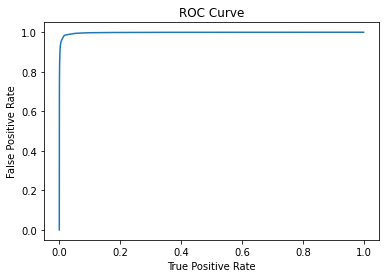

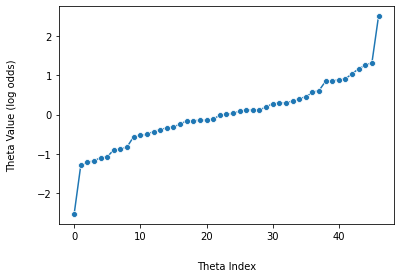

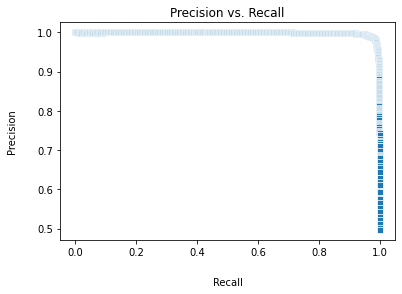

In [0]:
#Display our Logistic Regression's model Coeffitients and ROC curve over the TRAINING set, display precision-recall graph, print auc over training and test set

#ROC
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Coefficients

theta = np.sort(lrModel.coefficients)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
_ = sns.lineplot(x=range(0,len(lrModel.coefficients)), y=theta, marker="o", axes=ax)
_ = ax.set_xlabel("Theta Index", labelpad=20)
_ = ax.set_ylabel("Theta Value (log odds)", labelpad=20)

#Precision-Recall

prec_rec = trainingSummary.pr.toPandas()
fig1, ax1 = plt.subplots(1, 1, figsize=(6,4))
_ = sns.lineplot(x=prec_rec['recall'], y=prec_rec['precision'], marker="s", axes=ax1)
_ = ax1.set_xlabel("Recall", labelpad=20)
_ = ax1.set_ylabel("Precision", labelpad=20)
_ = ax1.set_title("Precision vs. Recall")

In [0]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
print('Test set areaUnderROC: ' + str(auc))

Training set areaUnderROC: 0.9980241146856723
Test set areaUnderROC: 0.9829843273334834

### - 2.1 Decision Tree

In [0]:
#Instantiate the Decision Tree Classifier and fit it to our previously processed training data
dt = DecisionTreeClassifier(featuresCol= 'features', labelCol="_c2")
dt_model = dt.fit(trainingData)

In [0]:
#...and make predictions for the test data
test_predictions =dt_model.transform(testData)
test_predictions.select("features", "prediction", "_c2").show(50)
tree_preds = dt_model.transform(testData)

+--------------------+----------+---+
 features|prediction|_c2|
+--------------------+----------+---+
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 0.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 0.0| 0|
(47,[0,1,2,5,8,9,...| 1.0| 0|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
(47,[0,1,2,5,8,9,...| 1.0| 1|
+--------------------+----------+---+
only showing top 50 rows

In [0]:
#Instantiate an evaluator, and compute Area under the ROC curve for the test set
eval_2 = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="_c2")
dt_auc = eval_2.evaluate(tree_preds)
dt_auc

Out[27]: 0.9678657118009277

### - 2.3 Random Forests

In [0]:
#Instantiate a Random Forest Classifier and train it on our training data 
rf = RandomForestClassifier(featuresCol= 'features', labelCol="_c2", numTrees=10)
rf_model =rf.fit(trainingData)

In [0]:
#Make predictions for the test set
rf_test_predictions = rf_model.transform(testData)
rf_tree_preds = rf_model.transform(testData)

In [0]:
#Instantiate an evaluator, and compute area under the ROC curve
eval_3 = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="_c2")
rf_auc = eval_3.evaluate(rf_tree_preds)
rf_auc

Out[50]: 0.9740809628051614

## 3. Feature Importance Analysis

One of the main goals in this project is to gain some insight regarding which features are associated to key objectives for victory in a league of legends game. For this reason, we now extract and display the feature importances computed by our most performing classifier: the Random Forest model. This function is a generalization of Sci-Kit's learn "Gini", which computes the importance of each feature by:


- summing the information gain for splitting the samples over that feature. 
- Normalizing these sums (importances), in order to get them to sum to 1.

We could have considered the feature importances of the Decision Classifier instead, but chose Random Forest for two reasons:

- It's our best performing model
- Importances for single decision trees can have high variances between different decision trees, while those computed by random forests are generally more accurate.

In [0]:
#Extract feature importances from the Random Forest Classifier
value = rf_model.featureImportances
value

Out[31]: SparseVector(47, {0: 0.0, 2: 0.0114, 3: 0.0005, 5: 0.0722, 6: 0.0118, 8: 0.1639, 9: 0.1581, 11: 0.001, 12: 0.0131, 13: 0.0244, 14: 0.0126, 16: 0.004, 17: 0.0004, 18: 0.002, 19: 0.0011, 20: 0.0, 21: 0.034, 22: 0.0013, 23: 0.0306, 25: 0.0006, 26: 0.0017, 27: 0.0, 28: 0.0497, 29: 0.0012, 30: 0.0218, 31: 0.124, 32: 0.0906, 35: 0.0385, 36: 0.0501, 37: 0.0237, 38: 0.0058, 39: 0.0128, 41: 0.0046, 42: 0.0079, 44: 0.0041, 45: 0.0004, 46: 0.0202})

In [0]:
#Save Values and indices of the resulting object into separate lists
values = rf_model.featureImportances.values.tolist()
indici = rf_model.featureImportances.indices.tolist()

#Create Dictionary
zip_iterator = zip(indici, values) 
a_dictionary = dict(zip_iterator)

#Sort Dictionary
sorted_dict = {k: v for k, v in sorted(a_dictionary.items(), key=lambda item: item[1])}

#Insert entries for features that were filtered by the random forest's GINI with value = 0
feature_dict = {}
for i in range(0, len(features)):
  try:
    feature_dict[i] = sorted_dict[i]
  except:
    feature_dict[i] = 0
feature_dict

Out[32]: {0: 2.6758554892471073e-05,
 1: 0,
 2: 0.011366479678171627,
 3: 0.0005401593733474382,
 4: 0,
 5: 0.0722028163236653,
 6: 0.011776932695858302,
 7: 0,
 8: 0.16387564974969657,
 9: 0.1581099921466688,
 10: 0,
 11: 0.0009763271379899333,
 12: 0.013063668118116578,
 13: 0.024408357686087085,
 14: 0.012572289809009549,
 15: 0,
 16: 0.004015998680981201,
 17: 0.000386169081630349,
 18: 0.001972472335070109,
 19: 0.0010587521089819953,
 20: 1.5397496010797507e-05,
 21: 0.034024011451773625,
 22: 0.0012775343879710074,
 23: 0.030592481980872388,
 24: 0,
 25: 0.0005887440654127939,
 26: 0.0017242765467942126,
 27: 1.6964182452687895e-05,
 28: 0.049657291931057404,
 29: 0.0012047676740854095,
 30: 0.021797347185183266,
 31: 0.1240051978827792,
 32: 0.09061155667817491,
 33: 0,
 34: 0,
 35: 0.038522656289756825,
 36: 0.050106637797296266,
 37: 0.023713019484524377,
 38: 0.005823758650314824,
 39: 0.012768779540013712,
 40: 0,
 41: 0.004620168169626785,
 42: 0.007906874862987634,
 43: 0,
 44: 0.004067634986043267,
 45: 0.0004016183764653749,
 46: 0.02020045690023579}

Out[33]:

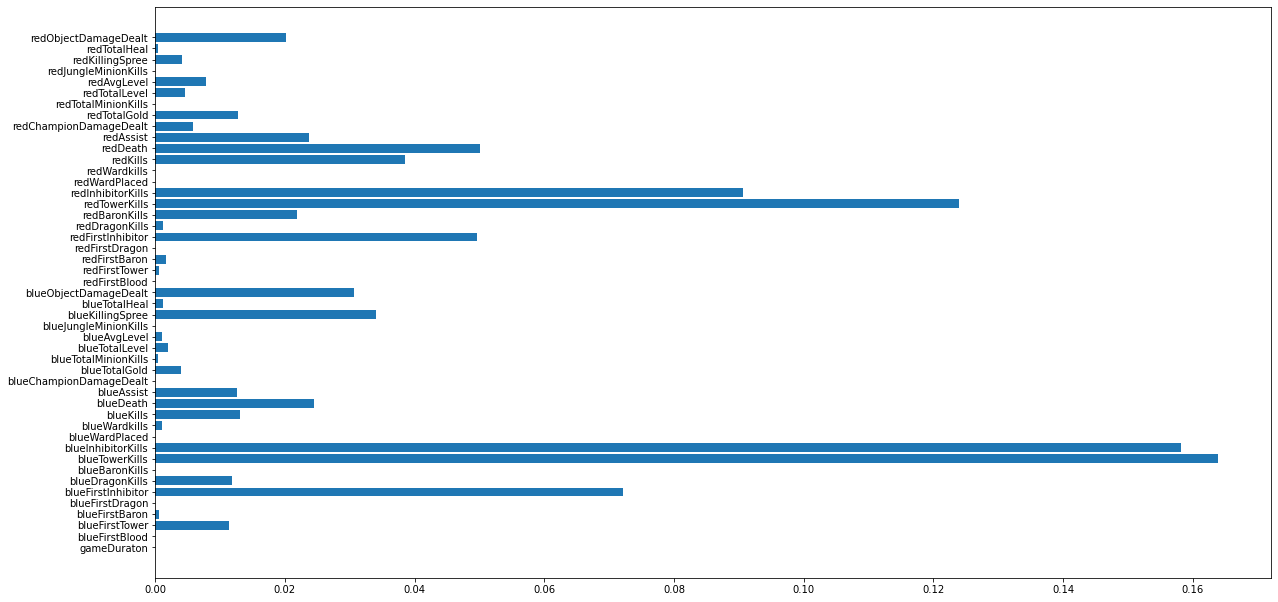

<function matplotlib.pyplot.show(*args, **kw)>

In [0]:
labels = [mapping[features[indice]] for indice in feature_dict]
values = [feature_dict[indice] for indice in feature_dict]
plt.barh(labels, values, height=0.8)
plt.xticks(rotation='horizontal')
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
fig.set_size_inches(20, 10.5, forward=True)
plt.show

In [0]:
#For each feature, compute the avarage of its value for all samples; create a dict of keys:values where keys = feature name, values = avarage
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
dfb = df.filter("_c2=1")
means = {}
for column in dfb.columns:
  df_stats = dfb.select(
      _mean(col(column)).alias('mean')
  ).collect()
  col_name = mapping[column]
  means[col_name] = df_stats[0]['mean']

  print(col_name, means[col_name])

gameDuraton 1425.857101069195
blueWins 1.0
blueFirstBlood 0.6106213435545693
blueFirstTower 0.7501613879362518
blueFirstBaron 0.39376639096227556
blueFirstDragon 0.5377748638289288
blueFirstInhibitor 0.705376235626387
blueDragonKills 1.9320556788380068
blueBaronKills 0.4882590276376841
blueTowerKills 6.786675408513213
blueInhibitorKills 1.1738047205971354
blueWardPlaced 54.24059915271334
blueWardkills 20.48800685898729
blueKills 30.43997377446036
blueDeath 18.97866653217672
blueAssist 50.200927980633445
blueChampionDamageDealt 75469.30128101674
blueTotalGold 52031.46837805124
blueTotalMinionKills 512.4368569699415
blueTotalLevel 67.67163607020375
blueAvgLevel 13.142475287472262
blueJungleMinionKills 137.1669961670365
blueKillingSpree 7.124783134960662
blueTotalHeal 27431.97985676821
blueObjectDamageDealt 51133.804922332056
redFirstBlood 0.38698809763970143
redFirstTower 0.2379463385111963
redFirstBaron 0.08621141819648981
redFirstDragon 0.34690336897316926
redFirstInhibitor 0.056394996973976194
redDragonKills 0.9050231995158362
redBaronKills 0.11598749243494048
redTowerKills 1.8044684284849708
redInhibitorKills 0.11563445632438975
redWardPlaced 51.7074339318136
redWardkills 17.78739156748033
redKills 18.867722412749647
redDeath 30.504357474278798
redAssist 30.458129917288684
redChampionDamageDealt 62725.77470244099
redTotalGold 43524.94220294533
redTotalMinionKills 486.96639096227557
redTotalLevel 61.599626790397416
redAvgLevel 11.929039741779302
redJungleMinionKills 109.57572120234012
redKillingSpree 4.220677829332257
redTotalHeal 21329.45209804317
redObjectDamageDealt 21938.957484365543

In [0]:
#Repeat the same computation for the samples under examination
sample_means = {}
for column in sample.columns:
  df_stats = sample.select(
      _mean(col(column)).alias('mean')
  ).collect()
  col_name = mapping[column]
  sample_means[col_name] = df_stats[0]['mean']

  print(col_name, sample_means[col_name])

gameDuraton 1425.0
blueWins 0.7
blueFirstBlood 0.7
blueFirstTower 0.6
blueFirstBaron 0.35
blueFirstDragon 0.55
blueFirstInhibitor 0.65
blueDragonKills 1.85
blueBaronKills 0.35
blueTowerKills 5.85
blueInhibitorKills 0.75
blueWardPlaced 54.05
blueWardkills 20.85
blueKills 24.45
blueDeath 17.2
blueAssist 36.75
blueChampionDamageDealt 67261.45
blueTotalGold 46549.95
blueTotalMinionKills 536.95
blueTotalLevel 63.35
blueAvgLevel 12.2
blueJungleMinionKills 139.85
blueKillingSpree 5.65
blueTotalHeal 26820.15
blueObjectDamageDealt 44585.5
redFirstBlood 0.3
redFirstTower 0.4
redFirstBaron 0.2
redFirstDragon 0.45
redFirstInhibitor 0.1
redDragonKills 1.3
redBaronKills 0.35
redTowerKills 2.75
redInhibitorKills 0.25
redWardPlaced 53.45
redWardkills 19.25
redKills 17.05
redDeath 24.45
redAssist 28.45
redChampionDamageDealt 60547.85
redTotalGold 41694.05
redTotalMinionKills 501.85
redTotalLevel 60.75
redAvgLevel 11.65
redJungleMinionKills 129.65
redKillingSpree 3.45
redTotalHeal 24536.65
redObjectDamageDealt 31533.45

In [0]:
#Create a mapping, from labels to feature importance computed with Random Forest
label_to_importance = {label:value for (label,value) in zip(labels, values)}

In [0]:
#Compute Priority metric as defined in our report
priorities = {}
for i in means:
  if i != 'blueWins' and "red" not in i:
    priorities[i] = (means[i] - sample_means[i])*label_to_importance[i]/sample_means[i]
priorities

Out[37]: {'gameDuraton': 1.6094586672598334e-08,
 'blueFirstBlood': -0.0,
 'blueFirstTower': 0.0028446772740390864,
 'blueFirstBaron': 6.754521804531931e-05,
 'blueFirstDragon': -0.0,
 'blueFirstInhibitor': 0.006151261799427734,
 'blueDragonKills': 0.0005223590308044157,
 'blueBaronKills': 0.0,
 'blueTowerKills': 0.026239024132421428,
 'blueInhibitorKills': 0.08934368139377898,
 'blueWardPlaced': 0.0,
 'blueWardkills': -1.695077828954083e-05,
 'blueKills': 0.003200451101258578,
 'blueDeath': 0.002524088890793113,
 'blueAssist': 0.004601604483609231,
 'blueChampionDamageDealt': 0.0,
 'blueTotalGold': 0.00047290642795594866,
 'blueTotalMinionKills': -1.7629607843916775e-05,
 'blueTotalLevel': 0.00013455892013761626,
 'blueAvgLevel': 8.179079494054677e-05,
 'blueJungleMinionKills': -2.9539893324998076e-07,
 'blueKillingSpree': 0.008881068720846754,
 'blueTotalHeal': 2.9143523865778534e-05,
 'blueObjectDamageDealt': 0.00449314015412413}

Out[38]:

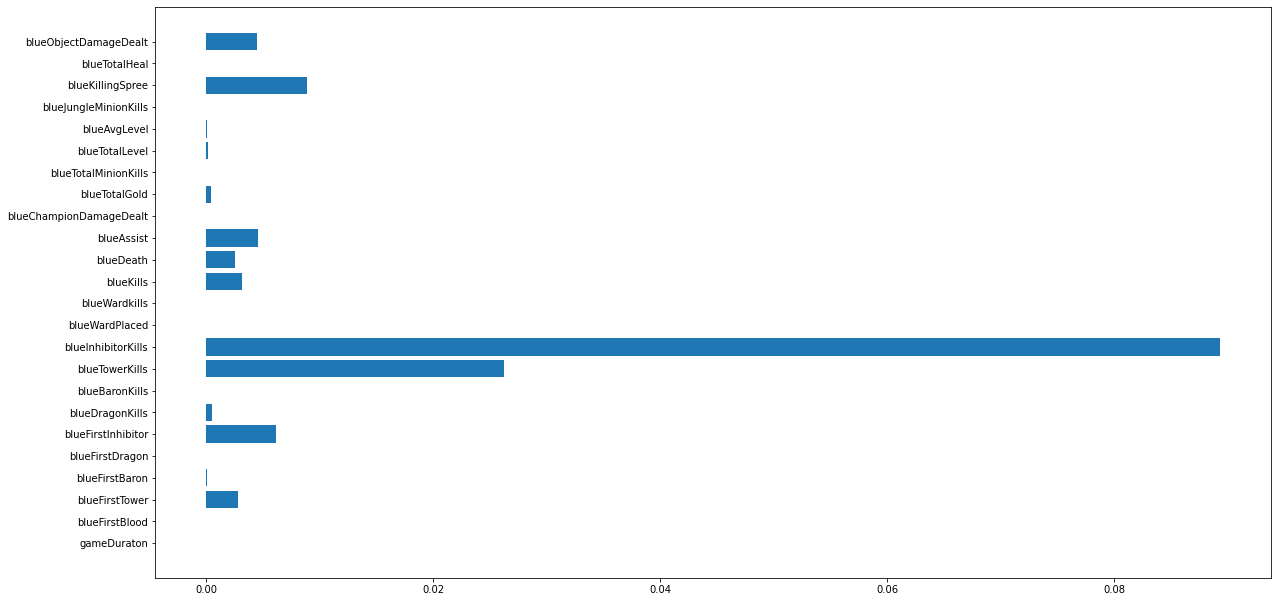

<function matplotlib.pyplot.show(*args, **kw)>

In [0]:
#Plot those that should be the prioritary objectives for the hypothetical team that provided us with their matches' data (samples)
labels = [i for i in priorities]
plt.barh(labels, priorities.values())
plt.xticks(rotation='horizontal')
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
fig.set_size_inches(20, 10.5, forward=True)
plt.show

Out[47]:

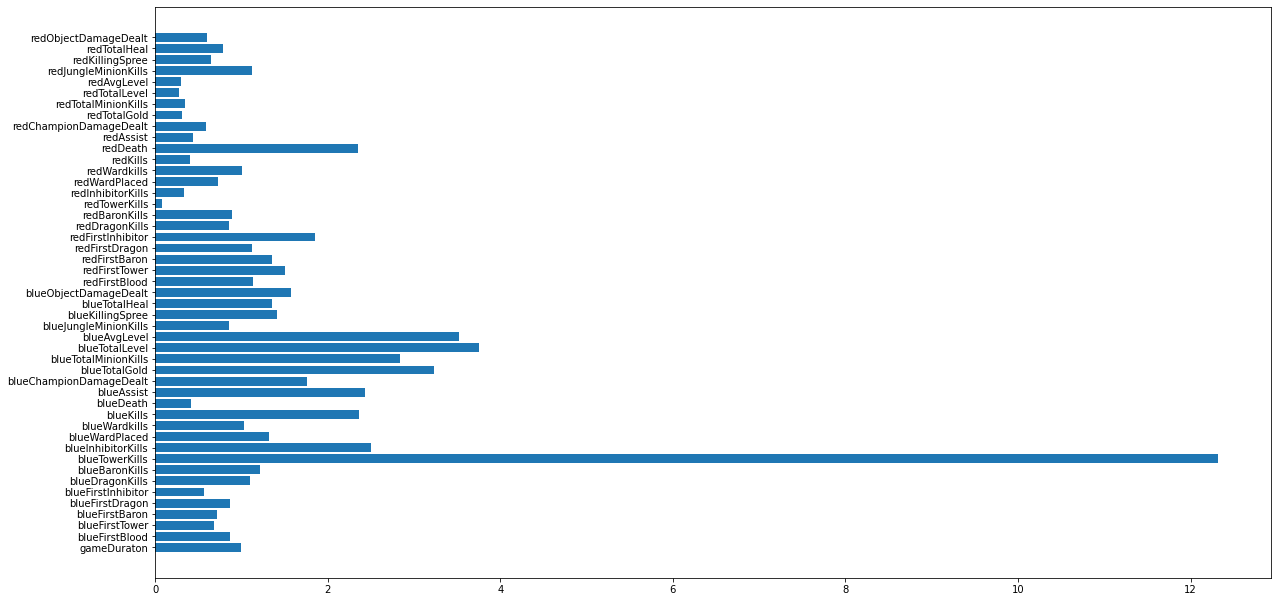

<function matplotlib.pyplot.show(*args, **kw)>

In [0]:
vals = np.exp(lrModel.coefficients)
labels = [mapping[features[indice]] for indice in feature_dict]
plt.barh(labels, vals, height=0.8)
plt.xticks(rotation='horizontal')
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
fig.set_size_inches(20, 10.5, forward=True)
plt.show

## 4. Conclusions

Our classification models, the Random Forest one in particular, succesfully separated the data right from the start; with some adjustments, the AUC metric reached nearly 0.99 on the test set. For this reason, we tried to get as much insight as possible on how RF was achieving such results by examining it's feature importances, in order to hypothetically transfer this knowledge to teams willing to improve their playstyle. The logistic regression model also gave similar results: the feature's odds ratio were proportionate to the importances of the previous model.
These importances reflected the feature's correlation with the target examined in the data exploration phase in most cases. Some of these correlations are fairly easy to infer knowing the game, but some of them aren't.  We tried to propose a playstyle improvement direction by combining each feature's importance with how teams play as the Blue side wrt the avarage blue-victory games in a home made metric, "priority".